In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## 3D meshing example

This notebook shows how to mesh a 3D volume:

1. Load and visualize a volume
2. Apply image filters and segment image
3. Generate a 3D surface mesh
4. Visualize and export the mesh to other formats

In [2]:

import pyvista as pv
from skimage import filters
import numpy as np


### Load and vizualize the data

Load the data from a numpy data file into a [`Volume`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) object using the `.load` method.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<IPython.core.display.Javascript object>


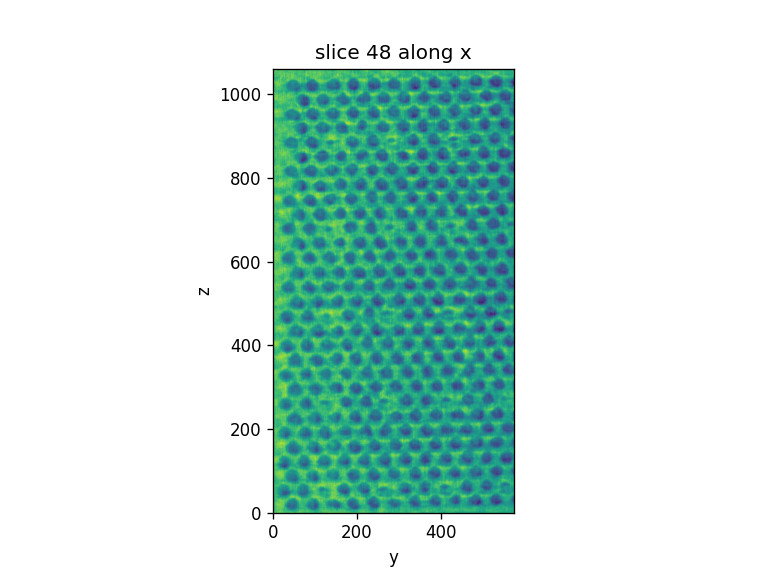

interactive(children=(IntSlider(value=48, description='index', max=99), RadioButtons(description='along', opti…

In [3]:
from nanomesh.volume import Volume

vol = Volume.load('slab_x450-550.npy')
vol.show_slice(x=48)

For this example, select a subvolume using `.select_subvolume` and downscale the image to keep the cpu times in check.

<IPython.core.display.Javascript object>


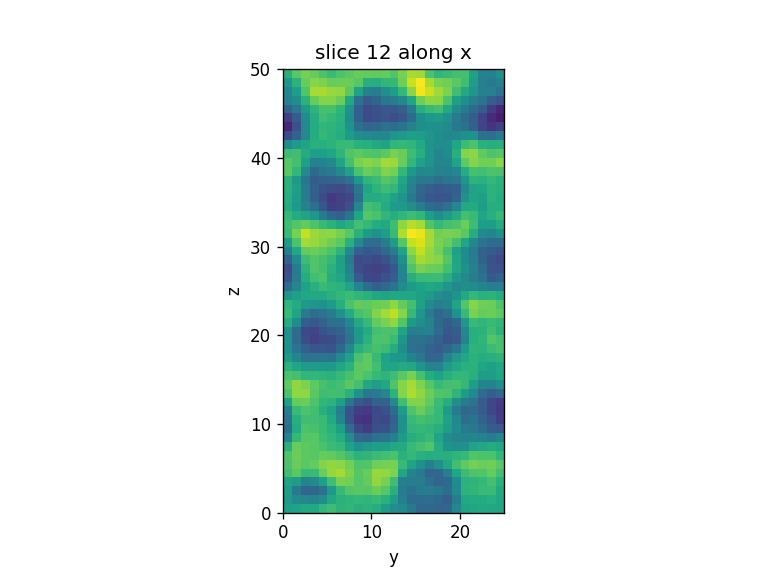

interactive(children=(IntSlider(value=12, description='index', max=24), RadioButtons(description='along', opti…

In [4]:
from skimage.transform import rescale

subvol = vol.select_subvolume(
    ys=(400,500), 
    zs=(600,800),
).apply(rescale, scale=0.25)
subvol.show_slice()

`nanomesh` makes use of [`itkwidgets`](https://github.com/InsightSoftwareConsortium/itkwidgets) to render the volumes.

In [5]:
subvol.show_volume()

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

### Filter and segment the data

Image segmentation is a way to label the pixels of different regions of interest in an image. In this example, we are interested in separating the bulk material (Si) from the nanopores. In the image, the Si is bright, and the pores are dark.

First, we apply a [`gaussian filter`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) to smooth out some of the image noise to get a cleaner segmentation.

<IPython.core.display.Javascript object>


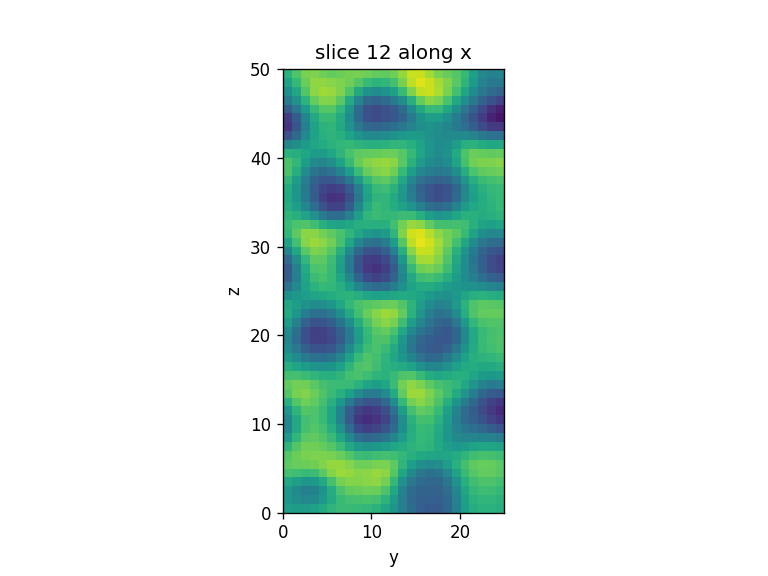

interactive(children=(IntSlider(value=12, description='index', max=24), RadioButtons(description='along', opti…

In [6]:
subvol_gauss = subvol.gaussian(sigma=1)
subvol_gauss.show_slice(x=12)

`scikit-image` contains a useful function to [try all threshold finders on the data](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold). These methods analyse the contrast histogram and try to find the optimal value to separate which parts of the image belong to each domain.

Since the function only works on a single slice, we first select a slice using the `.select_plane` method.

<IPython.core.display.Javascript object>


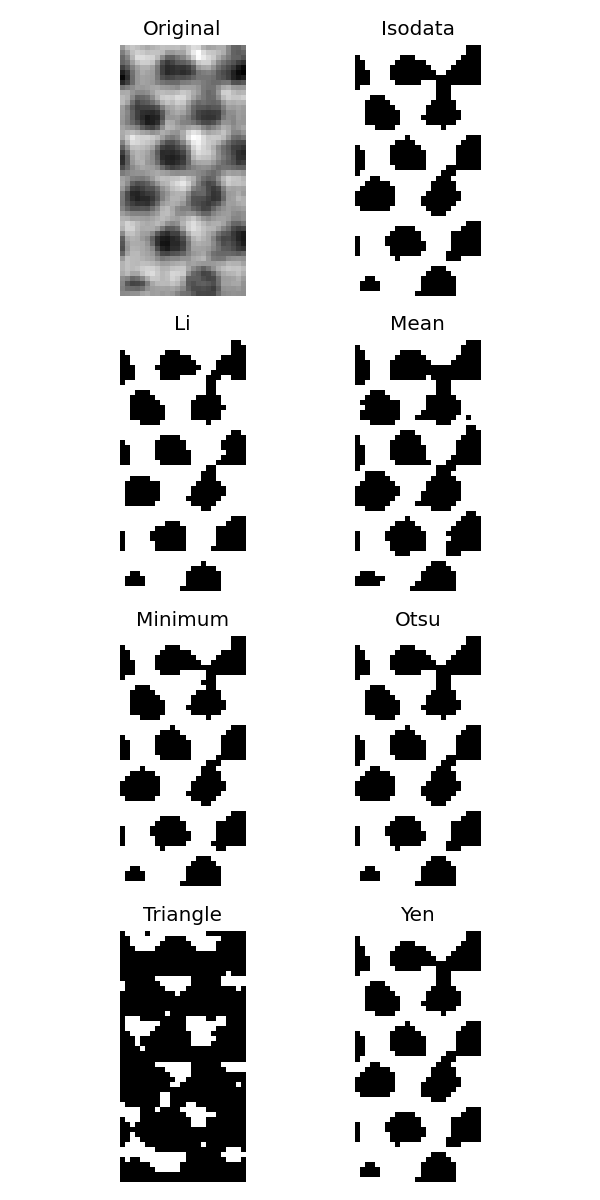

In [7]:
from skimage import filters

plane = subvol.select_plane(x=12)
plane.try_all_threshold(figsize=(5, 10))

We will use the `li` method, because it gives nice separation.

The threshold value is used to segment the image using [`np.digitize`](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html#numpy-digitize).

<IPython.core.display.Javascript object>


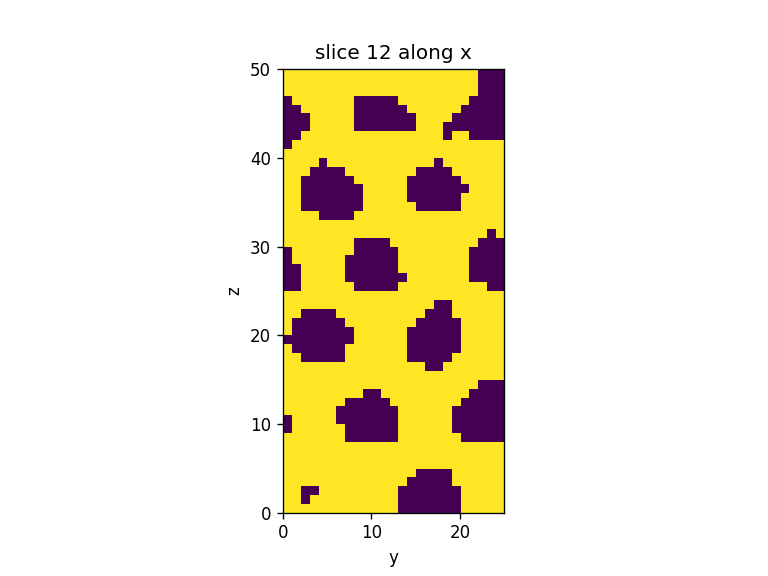

interactive(children=(IntSlider(value=12, description='index', max=24), RadioButtons(description='along', opti…

In [8]:
subvol_seg = subvol_gauss.binary_digitize(threshold='li')
subvol_seg.show_slice()

### Generate 3d tetragonal mesh

Meshes can be generated using the `Mesher3D` class. Meshing consists of two steps:

1. Contour finding (using the [`marching_cubes`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.marching_cubes) function
2. Triangulation (using the [`tetgen`](https://tetgen.pyvista.org/) library)

`Mesher3D` requires a segmented image. By specifying a `label`, `generate_contours` wraps all domains of the image corresponding to that label. Here, 1 corresponds to the bulk (Si) material.

Meshing options are defined in the [tetgen documentation](https://tetgen.pyvista.org/api.html#tetgen.TetGen.tetrahedralize). In short, `order=1` ensures linear tetrahedra are generated, `mindihedral=30` defines the minumum dihedral angle at 30°, and `minratio=1.1` specifies the maximum allowable radius-edge ratio as 1.1.

Note: at the moment `Mesher3D` is WIP and only supports single domain meshing.

In [9]:
%%time

from nanomesh.mesh3d import Mesher3D

mesher = Mesher3D(subvol_seg.image)
mesher.generate_contour(label=1, smooth=True)
mesh = mesher.tetrahedralize(
    label=1, 
    order=1, 
    mindihedral=30, 
    minratio=1.1, 
    verbose=2,
)

Generated contour with 28052  faces (label=1)
Wall time: 1.73 s


Tetrahedralization returns a `TetraMesh` dataclass that can be used for various operations, for example showing the result using `itkwidgets`:

In [10]:
mesh.plot_itk()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Alternatively, there is a method to show a cut through the mesh:

In [11]:
mesh.plot_submesh(color='orange')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Interoperability

The `TetraMesh` object can also be used to convert to various other library formats, such as:

- [`trimesh.open3d`](http://www.open3d.org/docs/release/python_api/open3d.geometry.TetraMesh.html#open3d.geometry.TetraMesh)
- [`pyvista.UnstructuredGrid`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)
- [`meshio.Mesh`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)

To save the data, use the `.write` method. This is essentially a very thin wrapper around `meshio`, equivalent to `meshio_mesh.write(...)`.

In [12]:
mesh.write('volume_mesh.msh', file_format='gmsh22', binary=False)

Appending zeros to replace the missing physical tag data.
Appending zeros to replace the missing geometrical tag data.
